## SMA Strategy

Let’s start off with a Simple Moving Average (SMA) strategy. We will start with a simple version of the strategy, namely:

Select the securities that are currently above their 50 day moving average
Weigh each selected security equally
Rebalance the portfolio to reflect the target weights
This should be pretty simple to build. The only thing missing above is the calculation of the simple moving average. When should this take place?

Given the flexibility of bt, there is no strict rule. The average calculation could be performed in an Algo, but that would be pretty inefficient. A better way would be to calculate the moving average at the beginning - before starting the backtest. After all, all the data is known in advance.

Now that we know what we have to do, let’s get started. First we will download some data and calculate the simple moving average.

In [1]:
import bt
import pandas as pd
%matplotlib inline

It’s always a good idea to plot your data to make sure it looks ok. So let’s see how the data + sma plot looks like.



Looks legit.

Now that we have our data, we will need to create our security selection logic. Let’s create a basic Algo that will select the securities that are above their moving average.

Before we do that, let’s think about how we will code it. We could pass the SMA data and then extract the row (from the sma DataFrame) on the current date, compare the values to the current prices, and then keep a list of those securities where the price is above the SMA. This is the most straightforward approach. However, this is not very re-usable because the logic within the Algo will be quite specific to the task at hand and if we wish to change the logic, we will have to write a new algo.

For example, what if we wanted to select securities that were below their sma? Or what if we only wanted securities that were 5% above their sma?

What we could do instead is pre-calculate the selection logic DataFrame (a fast, vectorized operation) and write a generic Algo that takes in this boolean DataFrame and returns the securities where the value is True on a given date. This will be must faster and much more reusable. Let’s see how the implementation looks like.

In [2]:
class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.
    Selects securities where the value is True on the current date (target.now).
    
    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)
    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.ix[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True


So just to recap, we created the strategy, created the backtest by joining Strategy+Data, and ran the backtest. Let’s see the results.



# Customized strategies

My “library” of backtests, you might want to write yourself a helper function that would allow you to test different parameters and securities.

In [3]:
def above_sma(tickers, sma_per=50, start='2015-01-01', name='above_sma'):
    """
    Long securities that are above their n period
    Simple Moving Averages with equal weights.
    """
    # download data
    data = bt.get(tickers, start=start)
    # calc sma
    sma = data.rolling(sma_per).mean()

    # create strategy
    s = bt.Strategy(name, [SelectWhere(data > sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

    # now we create the backtest
    return bt.Backtest(s, data)

This function allows us to easily generate backtests. We could easily compare a few different SMA periods. Also, let’s see if we can beat a long-only allocation to the SPY.



In [4]:
# simple backtest to test long-only allocation
def long_only_ew(tickers, start='2015-01-01', name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    data = bt.get(tickers, start=start)
    return bt.Backtest(s, data)

And there you have it. Beating the market ain’t that easy!

# SMA Crossover Strategy
Let’s build on the last section to test a moving average crossover strategy. The easiest way to achieve this is to build an Algo similar to SelectWhere, but for the purpose of setting target weights. Let’s call this algo WeighTarget. This algo will take a DataFrame of target weights that we will pre-calculate.

Basically, when the 50 day moving average will be above the 200-day moving average, we will be long (+1 target weight). Conversely, when the 50 is below the 200, we will be short (-1 target weight).

Here’s the WeighTarget implementation (this Algo also already exists in the algos module):

In [5]:
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.ix[target.now]

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True

So let’s start with a simple 50-200 day sma crossover for a single security.



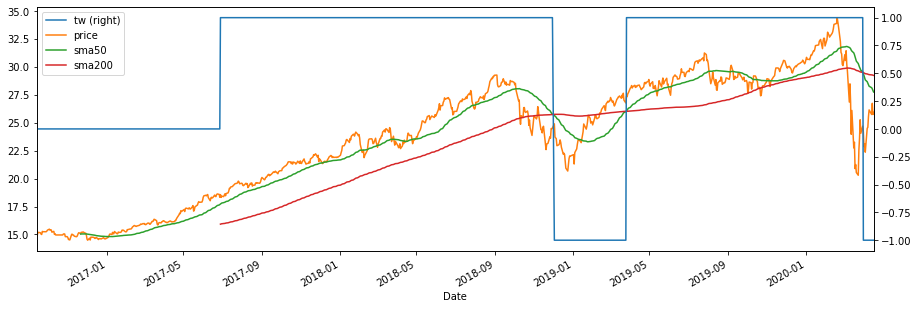

In [22]:
# start_dt='2018-01-01'
# data = bt.get('frel,sptl,voog,vwob,iau,zbh', start=start_dt)
# data.head()

## download some data & calc SMAs
data = bt.get('finx', start='2015-01-01')
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()

## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma200.copy()

# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0

# here we will set the weight to 0 - this is because the sma200 needs 200 data points before
# calculating its first point. Therefore, it will start with a bunch of nulls (NaNs).
tw[sma200.isnull()] = 0.0

# plot the target weights + chart of price & SMAs
tmp = bt.merge(tw, data, sma50, sma200)
tmp.columns = ['tw', 'price', 'sma50', 'sma200']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

Ok so we downloaded our data, calculated the simple moving averages, and then we setup our target weight (tw) DataFrame. Let’s take a look at our target weights to see if they make any sense.



As mentioned earlier, it’s always a good idea to plot your strategy data. It is usually easier to spot logic/programming errors this way, especially when dealing with lots of data.

Now let’s move on with the Strategy & Backtest.